In [1]:
# pip install pyshp  , https://pypi.org/project/pyshp/
# pip install geopandas 
# pip install bokeh
import shapefile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
g=9.81

In [2]:
## conda install -c conda-forge geopandas
## conda install descartes
import geopandas as gpd
import descartes
S = gpd.read_file("structural.shp")
HG = gpd.read_file("acceleration.shp")
HG.drop(columns=['X', 'Y'],inplace=True)

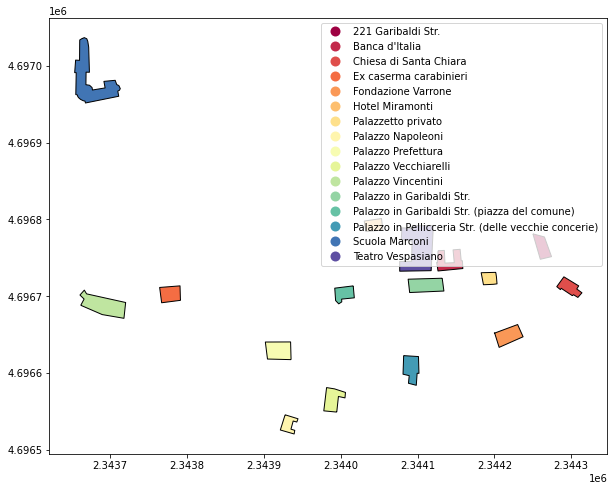

In [3]:
S.plot(cmap = "Spectral", column = "name" ,legend=True, edgecolor = "black" , figsize = (10,10)) #instead of cmap USE color = "red"
plt.show()

# Joint on nearest neighbors

In [4]:
from scipy.spatial import cKDTree
from shapely.geometry import Point
gpd1 = S[['name', 'geometry']].copy()
gpd2 = HG[["geometry",'Spectrum']].copy() 
# GET X,Y coordinates from Centroids and set geometry to those X,Y coordinates
def getXY(pt):
    return (pt.x, pt.y)
centroidseries = S['geometry'].centroid
X,Y = [list(t) for t in zip(*map(getXY, centroidseries))]
getXY
# make new columns for X,Y coordinates of centroids
gpd1["X"] = X
gpd1["Y"] = Y
# set geometry to X,Y
gpd1 = gpd.GeoDataFrame(gpd1, geometry=gpd.points_from_xy(gpd1.X, gpd1.Y))

def ckdnearest(gdA, gdB):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

joint = ckdnearest(gpd1, gpd2)
del gpd1
del gpd2
S["Spectrum"]=joint.Spectrum

In [5]:
# Make new column
S["typo1"] = np.NaN
S["typo2"] = np.NaN
S["typo3"] = np.NaN
S["typo4"] = np.NaN
S["typo5"] = np.NaN
S["typo6"] = np.NaN
S["use"] = np.NaN
S["WT"] = np.NaN
# Fill NAN values with default values
S.fillna({'typo1':3,'typo2':1,'typo3':2,'typo4':2,'typo5':1,'typo6':2,'use':1,'WT':0.60}, inplace=True)
Stemp = S.copy()

In [6]:
P1 = pd.DataFrame(np.zeros((len(S), 1)))
P2 = pd.DataFrame(np.zeros((len(S), 1)))
P3 = pd.DataFrame(np.zeros((len(S), 1)))
P4 = pd.DataFrame(np.zeros((len(S), 1)))
P5 = pd.DataFrame(np.zeros((len(S), 1)))
P6 = pd.DataFrame(np.zeros((len(S), 1)))

## STEP 3: Calculating the capacity curve for each building

In [7]:
typo = pd.DataFrame(S.typo1)
use = pd.DataFrame(S.use)
TH = pd.DataFrame(S.height)
Farea = pd.DataFrame(S.area)
Wthick = pd.DataFrame(S.WT)
Hstr = pd.DataFrame(S.typo2)
SS = pd.DataFrame(S.typo3)

In [8]:
Stemp["typo"] = typo
Stemp["use"] = use
Stemp["TH"] = TH
Stemp["Farea"] = Farea
Stemp["Wthick"] = Wthick
Stemp["Hstr"] = Hstr
Stemp["SS"] = SS
Stemp["Aside"]=Stemp["Farea"]**0.5

In [9]:
NS=TH/3
NS.loc[NS.height < 1, 'height'] = 1
Stemp["NS"] = NS

In [10]:
# average intestory height
ISH = ( TH / NS )
Stemp["ISH"] = ISH

 ##   3.1 Estimation of the eigenperiod %%%%%%%
 ### Approximate calculation of the eigenperiod. For masonry buildings (typo=1 to 7) an approximate calculation is made based on the footprint area Farea and assuming an approximate quadrangle shape. Then the formula of eurocode is applied (with analytical calculation of Ct (T11) and assuming Ct=0.050 (T12).ν Finally the minimum value is % selected. For RC buildings (typo=8,9,10) the value Ct=0.075 is selected.
    

In [11]:
from numpy import minimum
Aside = Farea ** 0.5
Ac = 2 * (Aside[0] * Wthick["WT"] * (0.2 + (Aside[0] / TH["height"])) ** 2)
Ct = 0.075 / np.sqrt(Ac)
T11 = Ct * TH["height"] ** (3 / 4)
T12 = 0.050 * TH["height"] ** (3 / 4)

typo.loc[(typo['typo1'] > 0) & (typo['typo1'] < 8)  ,  'T1'] = minimum(T11,T12)
typo.loc[(typo['typo1'] < 0) & (typo['typo1'] >= 8)  ,  'T1'] = 0.075 * TH["height"] ** (3 / 4)
Stemp["T1"]=typo["T1"]

## 3.2 Evaluation of the yielding, ay, acceleration of every building made of unreinforced masonry. Ιt covers only masonry structures

In [12]:
Stemp.loc[(Stemp['typo1'] == 1)  ,  't0'] = 0.03
Stemp.loc[Stemp['typo1'] == 1   ,  'gamma'] = 19
Stemp.loc[Stemp['typo1'] == 1   ,  'deltau'] = 0.004

Stemp.loc[Stemp['typo1'] == 2   ,  't0'] = 0.02
Stemp.loc[Stemp['typo1'] == 2   ,  'gamma'] = 15
Stemp.loc[Stemp['typo1'] == 2   ,  'deltau'] = 0.004

Stemp.loc[Stemp['typo1'] == 3   ,  't0'] = 0.07
Stemp.loc[Stemp['typo1'] == 3   ,  'gamma'] = 21
Stemp.loc[Stemp['typo1'] == 3   ,  'deltau'] = 0.007

Stemp.loc[Stemp['typo1'] == 4   ,  't0'] = 0.12
Stemp.loc[Stemp['typo1'] == 4   ,  'gamma'] = 22
Stemp.loc[Stemp['typo1'] == 4   ,  'deltau'] = 0.007

Stemp.loc[Stemp['typo1'] == 5   ,  't0'] = 0.09
Stemp.loc[Stemp['typo1'] == 5   ,  'gamma'] = 18

Stemp.loc[(Stemp['typo1'] == 5) & (Stemp['Hstr'] == 1)   ,  'deltau'] = 0.004
Stemp.loc[(Stemp['typo1'] == 5) & (Stemp['Hstr'] == 2)   ,  'deltau'] = 0.004
Stemp.loc[(Stemp['typo1'] == 5) & (Stemp['Hstr'] == 3)   ,  'deltau'] = 0.007
Stemp.loc[(Stemp['typo1'] == 5) & (Stemp['Hstr'] == 4)   ,  'deltau'] = 0.007

Stemp.loc[Stemp['typo1'] == 6   ,  't0'] = 0.12
Stemp.loc[Stemp['typo1'] == 6   ,  'gamma'] = 16
Stemp.loc[Stemp['typo1'] == 6   ,  'deltau'] = 0.007

Stemp.loc[Stemp['typo1'] == 7   ,  't0'] = 0.12
Stemp.loc[Stemp['typo1'] == 7   ,  'gamma'] = 22
Stemp.loc[Stemp['typo1'] == 7   ,  'deltau'] = 0.007

In [13]:
#Load (KN/m2)
Stemp.loc[Stemp['Hstr'] == 1   ,  'p'] = 2.0
Stemp.loc[Stemp['Hstr'] == 2   ,  'p'] = 7.0
Stemp.loc[Stemp['Hstr'] == 3   ,  'p'] = 3.5
Stemp.loc[(Stemp['Hstr'] == 4) & (Stemp['use'] == 1)  ,  'p'] = 2
Stemp.loc[(Stemp['Hstr'] == 4) & (Stemp['use'] == 2)  ,  'p'] = 5

In [14]:
# Compressive strength (MPa)
Stemp["sigma0"]=(Stemp["NS"]*Stemp["p"]+Stemp["gamma"]*Stemp["Farea"]*Stemp["ISH"]* (1+(Stemp["NS"]-1)**1.3) )/100
# Shear strenth
Stemp["t"]=Stemp["t0"]* ((1+Stemp["sigma0"]/Stemp["t0"])**0.5)

In [15]:
xi=1.0
Stemp["a1"]=2* (Stemp["Aside"] * Stemp["Wthick"])/Stemp["Farea"]
# Yielding acceleration ay
Stemp["ay"] = 0.5*(Stemp["t"]*Stemp["a1"]*xi*(0.8+0.2*Stemp["NS"])) /  (0.75+0.25*(Stemp["NS"]**(-0.75))*Stemp["sigma0"])
# Modal participation factor
Stemp["lambda"] = (2/3+(1/(3*Stemp["NS"])))**(-1)
# Calculate the yield displacement as follows
Stemp["dy"]=9.81*(Stemp["ay"]*(Stemp["T1"]/(2*np.pi))**2);
# Ultimate displacement du
Stemp.loc[Stemp['SS'] == 1   ,  'du'] = Stemp["deltau"]*Stemp["ISH"]+Stemp["dy"]*(1-Stemp["lambda"]/Stemp["NS"])
Stemp.loc[Stemp['SS'] == 2   ,  'du'] = Stemp["deltau"]*Stemp["NS"]*Stemp["ISH"]/Stemp["lambda"]
# Ductility
Stemp["m"]=Stemp["du"]/Stemp["dy"]
# Define damage limit states
Stemp["Sd1"]=0.7*Stemp["dy"]
Stemp.loc[ 1.5*Stemp['dy'] < 0.5*(Stemp['dy']+Stemp['du'])    ,  'Sd2'] = 1.5*Stemp['dy']
Stemp.loc[ 1.5*Stemp['dy'] >= 0.5*(Stemp['dy']+Stemp['du'])    ,  'Sd2'] = Stemp['dy']
Stemp["Sd3"]=0.5*(Stemp["dy"]+Stemp["du"])
Stemp["Sd4"]=Stemp["du"]

In [16]:
# Parameter for agR
alpha=range(0,1,101)

## 4.0 Seismic Hazard

In [17]:
#Calculate the center of each BoundingBox and the relevant spectrum  based on the nearest point of acceleration

In [18]:
#get centroids to a list
def getXY(pt):
    return (pt.x, pt.y)
centroidseries = S['geometry'].centroid
Xcen,Ycen = [list(t) for t in zip(*map(getXY, centroidseries))]
getXY
Stemp["Xcen"] = Xcen
Stemp["Ycen"] = Ycen

In [19]:
def find_nearest(array,value):
    array= np.asarray(array)
    idx=(np.abs(array-value)).argmin()
    pos = np.where(T7 == idx)
    return array[idx],pos

In [20]:
# READ and store Spectrum *.txt files 
import glob
import pandas as pd
import csv 
spec= pd.DataFrame()
print(glob.glob("*.txt")) 
mylist = [f for f in glob.glob("*.txt")]
dict={}
dict={"1":[],"2":[],"3":[],"4":[],"5":[],"6":[],"7":[],"8":[],"9":[],"10":[],}
for i in mylist:
    df = pd.read_csv(i, index_col=None, sep='\s+',header=None)
    
    names= i
    names = names.translate({ord('t'): None})
    names = names.translate({ord('x'): None})
    names = names.translate({ord('.'): None})
    
    dict[names].append(df)
    
print(dict)
asd = list(dict.items())
asd = np.array(asd)
asd

try:
    spec["T1"]=asd[0][1][0][0]
    spec["SV1"]=(9.81*asd[0][1][0][1] * ( spec.T7/ (2*np.pi)   ))
    Stemp["TC1"]=spec.SV1.max()
    Stemp["Sae1"]= np.nan
    T1 = np.asarray(spec.T1)
    SV1 = np.asarray(spec.SV1)
    for i in range(len(S)):
        idx , pos = find_nearest(T1,Stemp.T1[i])
#find position of nearest value in T7
        print("T1", i)
        pos = np.where(spec["T1"] == idx)
        pos = pos[0][0]
        SV1= pd.DataFrame(SV1)
        Sae1= g*SV1.loc[pos,0]
        Stemp["Sae1"][i]= Sae1
except:
    pass

try:
    spec["T2"]=asd[1][1][0][0]
    spec["SV2"]=(9.81*asd[1][1][0][1] * ( spec.T7/ (2*np.pi)   ))
    Stemp["TC2"]=spec.SV2.max()
    Stemp["Sae2"]= np.nan
    T2 = np.asarray(spec.T2)
    SV2 = np.asarray(spec.SV2)
    for i in range(len(S)):
        idx , pos = find_nearest(T2,Stemp.T1[i])
#find position of nearest value in T7
        print("T2", i)
        pos = np.where(spec["T2"] == idx)
        pos = pos[0][0]
        SV2 = pd.DataFrame(SV2)
        Sae2 = g*SV2.loc[pos,0]
        Stemp["Sae2"][i]= Sae2
except:
    pass

try:
    spec["T3"]=asd[2][1][0][0]
    spec["SV3"]=(9.81*asd[2][1][0][1] * ( spec.T7/ (2*np.pi)   ))
    Stemp["TC3"]=spec.SV3.max()
    Stemp["Sae3"]= np.nan
    T3 = np.asarray(spec.T3)
    SV3 = np.asarray(spec.SV3)
    for i in range(len(S)):
        idx , pos = find_nearest(T3,Stemp.T1[i])
#find position of nearest value in T7
        print("T3", i)
        pos = np.where(spec["T3"] == idx)
        pos = pos[0][0]
        SV6= pd.DataFrame(SV6)
        Sae3= g*SV3.loc[pos,0]
        Stemp["Sae3"][i]= Sae3
except:
    pass

try:
    spec["T4"]=asd[3][1][0][0]
    spec["SV4"]=(9.81*asd[3][1][0][1] * ( spec.T7/ (2*np.pi)   ))
    Stemp["TC4"]=spec.SV4.max()
    Stemp["Sae4"]= np.nan
    T4 = np.asarray(spec.T4)
    SV4 = np.asarray(spec.SV4)
    for i in range(len(S)):
        idx , pos = find_nearest(T4,Stemp.T1[i])
#find position of nearest value in T7
        print("T4", i)
        pos = np.where(spec["T4"] == idx)
        pos = pos[0][0]
        SV4= pd.DataFrame(SV4)
        Sae4= g*SV4.loc[pos,0]
        Stemp["Sae4"][i]= Sae4
except:
    pass

try:
    spec["T5"]=asd[4][1][0][0]
    spec["SV5"]=(9.81*asd[4][1][0][1] * ( spec.T7/ (2*np.pi)   ))
    Stemp["TC5"]=spec.SV5.max()
    Stemp["Sae5"]= np.nan
    T5 = np.asarray(spec.T5)
    SV5 = np.asarray(spec.SV5)
    for i in range(len(S)):
        idx , pos = find_nearest(T5,Stemp.T1[i])
#find position of nearest value in T7
        print("T5", i)
        pos = np.where(spec["T5"] == idx)
        pos = pos[0][0]
        SV5= pd.DataFrame(SV5)
        Sae5= g*SV5.loc[pos,0]
        Stemp["Sae5"][i]= Sae5
    
except:
    pass

try:
    spec["T6"]=asd[5][1][0][0]
    spec["SV6"]=(9.81*asd[5][1][0][1] * ( spec.T7/ (2*np.pi)   ))
    Stemp["TC6"]=spec.SV6.max()
    Stemp["Sae6"]= np.nan
    T6 = np.asarray(spec.T6)
    SV6 = np.asarray(spec.SV6)
    for i in range(len(S)):
        idx , pos = find_nearest(T6,Stemp.T1[i])
#find position of nearest value in T7
        print("T6", i)
        pos = np.where(spec["T6"] == idx)
        pos = pos[0][0]
        SV6= pd.DataFrame(SV6)
        Sae6= g*SV6.loc[pos,0]
        Stemp["Sae6"][i]= Sae6
except:
    pass


try:
    spec["T7"]=asd[6][1][0][0]
    spec["SV7"]=(9.81*asd[6][1][0][1] * ( spec.T7/ (2*np.pi)   ))
    Stemp["TC7"]=spec.SV7.max()
    Stemp["Sae7"]= np.nan
    T7 = np.asarray(spec.T7)
    SV7 = np.asarray(spec.SV7)
    for i in range(len(S)):
        idx , pos = find_nearest(T7,Stemp.T1[i])
#find position of nearest value in T7
        print("T7", i)
        pos = np.where(spec["T7"] == idx)
        pos = pos[0][0]
        SV7= pd.DataFrame(SV7)
        Sae7= g*SV7.loc[pos,0]
        Stemp["Sae7"][i]= Sae7
        print("T1:  ",Stemp.T1[i])
        print("T7 closest value to T1:  ",T7[pos])
        print("position of nearest value of T7 to T1:  ",pos)
        print("Value of SV7 which corresponds to the avove position :  ",SV7.loc[pos,0])
        print("Sae7 value :  ",Sae7)
       
except:
    pass


try:
    spec["T8"]=asd[7][1][0][0]
    spec["SV8"]=(9.81*asd[7][1][0][1] * ( spec.T7/ (2*np.pi)   ))
    Stemp["TC8"]=spec.SV8.max()
    Stemp["Sae8"]= np.nan
    T8 = np.asarray(spec.T8)
    SV8 = np.asarray(spec.SV8)
    for i in range(len(S)):
        idx , pos = find_nearest(T8,Stemp.T1[i])
#find position of nearest value in T7
        print("T8", i)
        pos = np.where(spec["T8"] == idx)
        pos = pos[0][0]
        SV8= pd.DataFrame(SV8)
        Sae8= g*SV8.loc[pos,0]
        Stemp["Sae8"][i]= Sae8
     
except:
    pass

try:
    spec["T9"]=asd[8][1][0][0]
    spec["SV9"]=(9.81*asd[8][1][0][1] * ( spec.T7/ (2*np.pi)   ))
    Stemp["TC9"]=spec.SV9.max()
    Stemp["Sae9"]= np.nan
    T9 = np.asarray(spec.T9)
    SV9 = np.asarray(spec.SV9)
    for i in range(len(S)):
        idx , pos = find_nearest(T9,Stemp.T1[i])
#find position of nearest value in T7
        print("T9", i)
        pos = np.where(spec["T9"] == idx)
        pos = pos[0][0]
        SV9= pd.DataFrame(SV9)
        Sae9= g*SV9.loc[pos,0]
        Stemp["Sae9"][i]= Sae9
except:
    pass


['7.txt', '8.txt', '9.txt']
{'1': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [         0       1
0   0.0100  0.3241
1   0.0106  0.3243
2   0.0113  0.3245
3   0.0120  0.3248
4   0.0127  0.3251
..     ...     ...
95  3.1400  0.0273
96  3.3359  0.0249
97  3.5440  0.0231
98  3.7651     NaN
99  4.0000     NaN

[100 rows x 2 columns]], '8': [         0       1
0   0.0100  0.2436
1   0.0106  0.2437
2   0.0113  0.2439
3   0.0120  0.2440
4   0.0127  0.2442
..     ...     ...
95  3.1400  0.0296
96  3.3359  0.0265
97  3.5440  0.0241
98  3.7651  0.0222
99  4.0000  0.0203

[100 rows x 2 columns]], '9': [         0       1
0   0.0100  0.2600
1   0.0106  0.2601
2   0.0113  0.2602
3   0.0120  0.2603
4   0.0127  0.2604
..     ...     ...
95  3.1400  0.0324
96  3.3359  0.0291
97  3.5440  0.0257
98  3.7651  0.0231
99  4.0000  0.0211

[100 rows x 2 columns]], '10': []}
T7 0
T1:   0.10127457736300052
T7 closest value to T1:   0.0997
position of nearest value of T7 to T1:   38
Value of SV7 which 

C:\Users\Quantum\AppData\Local\Temp/ipykernel_32216/3217743192.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  asd = np.array(asd)
C:\Users\Quantum\AppData\Local\Temp/ipykernel_32216/3217743192.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Stemp["Sae7"][i]= Sae7
C:\Users\Quantum\AppData\Local\Temp/ipykernel_32216/3217743192.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Stemp["Sae7

In [21]:
TD=4.0

In [22]:
# Estimate the performance point Sdd (m)
Stemp.loc[(Stemp['T1'] < Stemp['TC7']) & (Stemp['Sae7'] / Stemp['ay']  >= 1)  &  (Stemp.Spectrum == 7   )    ,  'Sdd'] = (1+(Stemp.Sae7/Stemp.ay-1.0)*(Stemp.TC7/Stemp.T1))*Stemp.dy;
Stemp.loc[(Stemp['T1'] >= Stemp['TC7']) & (Stemp['T1'] < TD) &  (Stemp.Spectrum == 7   )  ,  'Sdd'] = Stemp.Sae7*Stemp.dy/Stemp.ay
Stemp.loc[(Stemp['Sae7']/Stemp['ay'] <= 1)   &  (Stemp.Spectrum == 7   )  ,  'Sdd'] = Stemp.Sae7*Stemp.dy/Stemp.ay;
Stemp.loc[(Stemp['T1'] >= TD)   &  (Stemp.Spectrum == 7   )  ,  'Sdd'] = Sae7*TD*TD/(4*np.pi*np.pi); #EC8SPEC(agR,2,2,TD,5)*TD*TD/(4*pi*pi);

In [23]:
# Estimate the performance point Sdd (m)
Stemp.loc[(Stemp['T1'] < Stemp['TC8']) & (Stemp['Sae8'] / Stemp['ay']  >= 1)  &  (Stemp.Spectrum == 8   )    ,  'Sdd'] = (1+(Stemp.Sae8/Stemp.ay-1.0)*(Stemp.TC8/Stemp.T1))*Stemp.dy;
Stemp.loc[(Stemp['T1'] >= Stemp['TC8']) & (Stemp['T1'] < TD) &  (Stemp.Spectrum == 8   )  ,  'Sdd'] = Stemp.Sae8*Stemp.dy/Stemp.ay
Stemp.loc[(Stemp['Sae8']/Stemp['ay'] <= 1)   &  (Stemp.Spectrum == 8   )  ,  'Sdd'] = Stemp.Sae8*Stemp.dy/Stemp.ay;
Stemp.loc[(Stemp['T1'] >= TD)   &  (Stemp.Spectrum == 8   )  ,  'Sdd'] = Sae8*TD*TD/(4*np.pi*np.pi);  #EC8SPEC(agR,2,2,TD,5)*TD*TD/(4*pi*pi);

In [24]:
# Estimate the performance point Sdd (m)
Stemp.loc[(Stemp['T1'] < Stemp['TC9']) & (Stemp['Sae9'] / Stemp['ay']  >= 1)  &  (Stemp.Spectrum == 9   )    ,  'Sdd'] = (1+(Stemp.Sae9/Stemp.ay-1.0)*(Stemp.TC9/Stemp.T1))*Stemp.dy;
Stemp.loc[(Stemp['T1'] >= Stemp['TC9']) & (Stemp['T1'] < TD) &  (Stemp.Spectrum == 9   )  ,  'Sdd'] = Stemp.Sae9*Stemp.dy/Stemp.ay
Stemp.loc[(Stemp['Sae9']/Stemp['ay'] <= 1)   &  (Stemp.Spectrum == 9   )  ,  'Sdd'] = Stemp.Sae9*Stemp.dy/Stemp.ay;
Stemp.loc[(Stemp['T1'] >= TD)   &  (Stemp.Spectrum == 9   )  ,  'Sdd'] = Sae9*TD*TD/(4*np.pi*np.pi);  #EC8SPEC(agR,2,2,TD,5)*TD*TD/(4*pi*pi);

# STEP 5: Seismic Risk Calculation for building

In [25]:
# normalised standard deviation ‚ of the natural logarithm of the
#         displacement % threshold Sd,k has been defined as a function
#         of the capacity curve ductility 


In [26]:
from scipy.stats import norm
S["P1"]= Stemp["P1"]=norm.cdf(np.log(Stemp.Sdd/Stemp.Sd1)/(0.4*np.log(Stemp.m)))
S["P2"]= Stemp["P2"]=norm.cdf(np.log(Stemp.Sdd/Stemp.Sd2)/(0.4*np.log(Stemp.m)))
S["P3"]= Stemp["P3"]=norm.cdf(np.log(Stemp.Sdd/Stemp.Sd3)/(0.4*np.log(Stemp.m)))
S["P4"]= Stemp["P4"]=norm.cdf(np.log(Stemp.Sdd/Stemp.Sd4)/(0.4*np.log(Stemp.m)))

# STEP 6: Plotting Risk Maps

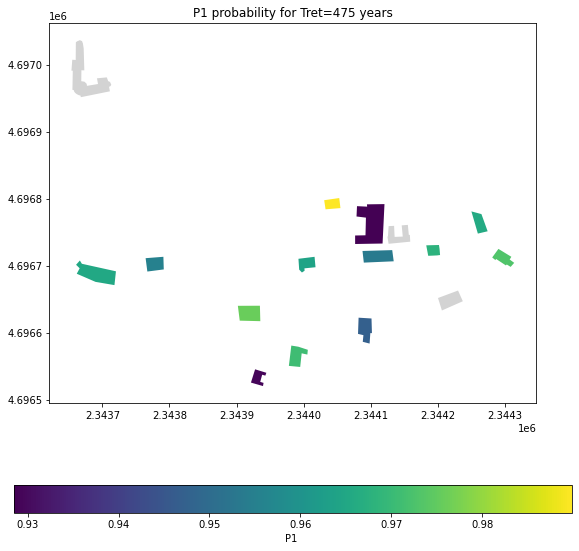

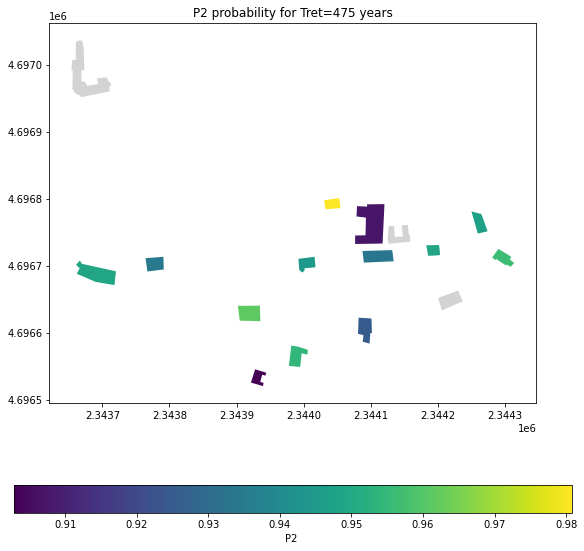

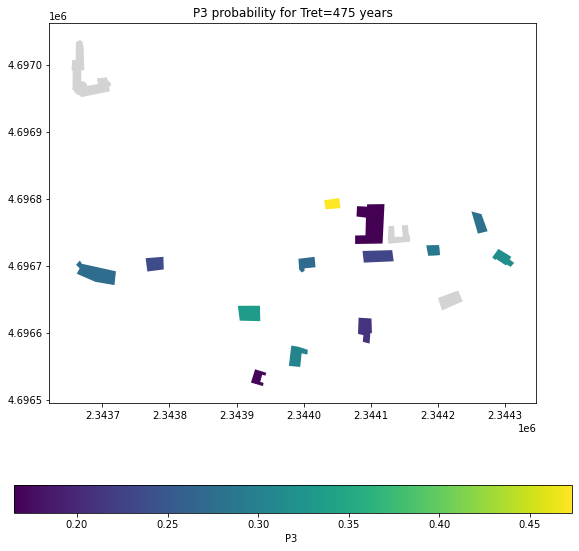

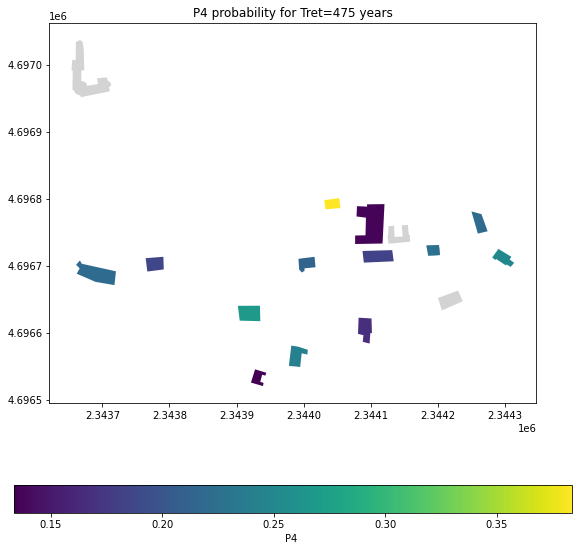

In [27]:

Stemp.plot(column='P1', legend=True, legend_kwds={'label': "P1 ",'orientation': "horizontal"}, missing_kwds={'color': 'lightgrey'},figsize=(10,10))
plt.title("P1 probability for Tret=475 years")
plt.savefig("P1.png")
Stemp.plot(column='P2', legend=True, legend_kwds={'label': "P2 ",'orientation': "horizontal"}, missing_kwds={'color': 'lightgrey'},figsize=(10,10))
plt.title("P2 probability for Tret=475 years")
plt.savefig("P2.png")
Stemp.plot(column='P3', legend=True, legend_kwds={'label': "P3 ",'orientation': "horizontal"}, missing_kwds={'color': 'lightgrey'},figsize=(10,10))
plt.title("P3 probability for Tret=475 years")
plt.savefig("P3.png")
Stemp.plot(column='P4', legend=True, legend_kwds={'label': "P4 ",'orientation': "horizontal"}, missing_kwds={'color': 'lightgrey'},figsize=(10,10))
plt.title("P4 probability for Tret=475 years")
plt.savefig("P4.png")


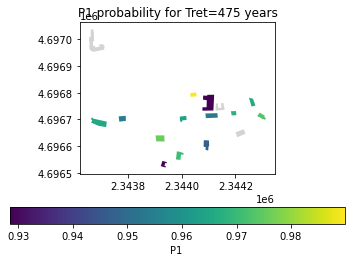

In [28]:
Stemp.plot(column='P1', legend=True, legend_kwds={'label': "P1 ",'orientation': "horizontal"}, missing_kwds={'color': 'lightgrey'})
plt.title("P1 probability for Tret=475 years")
plt.savefig("P1.png")

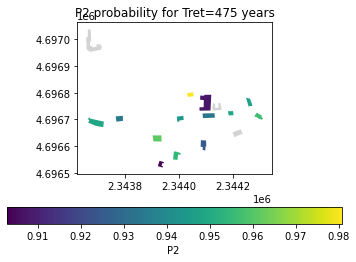

In [29]:
Stemp.plot(column='P2', legend=True, legend_kwds={'label': "P2 ",'orientation': "horizontal"}, missing_kwds={'color': 'lightgrey'})
plt.title("P2 probability for Tret=475 years")
plt.savefig("P2.png")

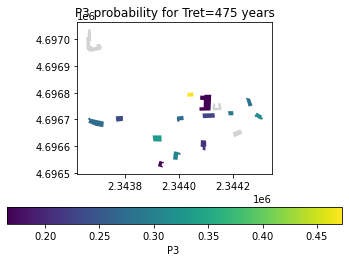

In [30]:
Stemp.plot(column='P3', legend=True, legend_kwds={'label': "P3 ",'orientation': "horizontal"}, missing_kwds={'color': 'lightgrey'})
plt.title("P3 probability for Tret=475 years")
plt.savefig("P3.png")

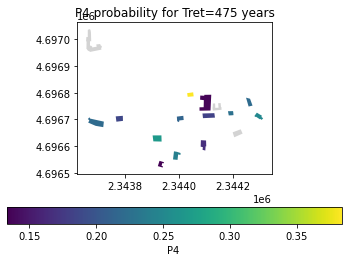

In [31]:
Stemp.plot(column='P4', legend=True, legend_kwds={'label': "P4 ",'orientation': "horizontal"}, missing_kwds={'color': 'lightgrey'})
plt.title("P4 probability for Tret=475 years")
plt.savefig("P4.png")

In [32]:
#S.plot(kind='scatter', x="id", y="P1")
#S.plot(kind='scatter', x="id", y="P2")
#S.plot(kind='scatter', x="id", y="P3")
#S.plot(kind='scatter', x="id", y="P4")

In [33]:
#ax = S.plot(column='name', categorical=True, legend=True, \
#             legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5),
#                         'fmt': "{:.0f}"}) # fmt is ignored for categorical data

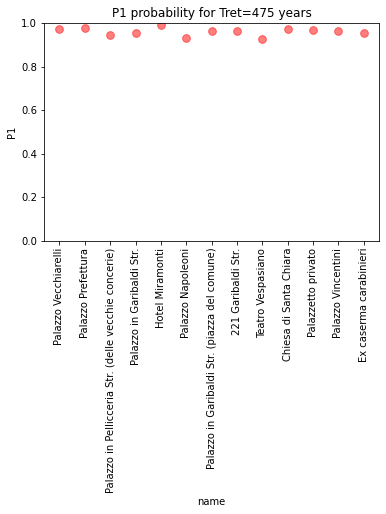

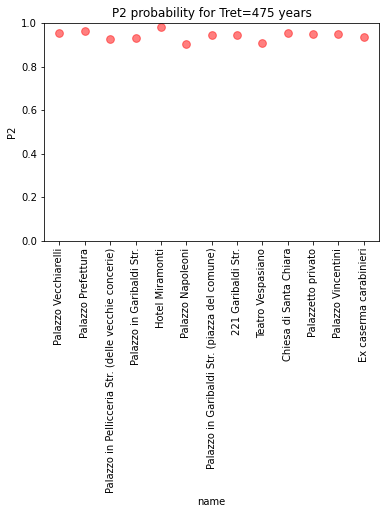

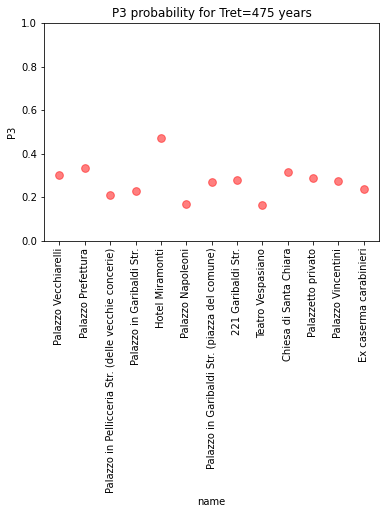

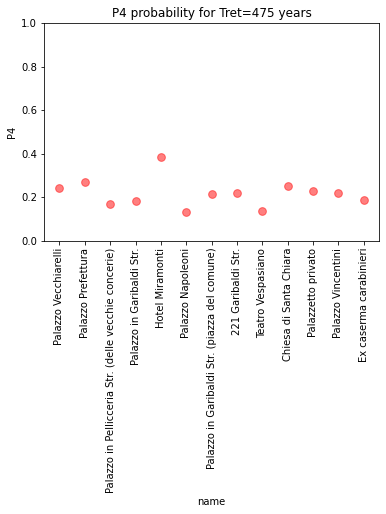

In [34]:
x = S.name
y1 = S.P1
s = 60

plt.scatter(x, y1, s, c="r", alpha=0.5)
plt.xlabel("name")
plt.ylabel("P1")
plt.ylim([0, 1])
plt.xticks(rotation = 90)
plt.title("P1 probability for Tret=475 years")
plt.show()

x = S.name
y2 = S.P2


plt.scatter(x, y2, s, c="r", alpha=0.5)
plt.xlabel("name")
plt.ylabel("P2")
plt.ylim([0, 1])
plt.xticks(rotation = 90)
plt.title("P2 probability for Tret=475 years")
plt.show()

x = S.name
y3 = S.P3


plt.scatter(x, y3, s, c="r", alpha=0.5)
plt.xlabel("name")
plt.ylabel("P3")
plt.ylim([0, 1])
plt.xticks(rotation = 90)
plt.title("P3 probability for Tret=475 years")
plt.show()


x = S.name
y4 = S.P4


plt.scatter(x, y4, s, c="r", alpha=0.5)
plt.xlabel("name")
plt.ylabel("P4")
plt.ylim([0, 1])
plt.xticks(rotation = 90)
plt.title("P4 probability for Tret=475 years")
plt.show()

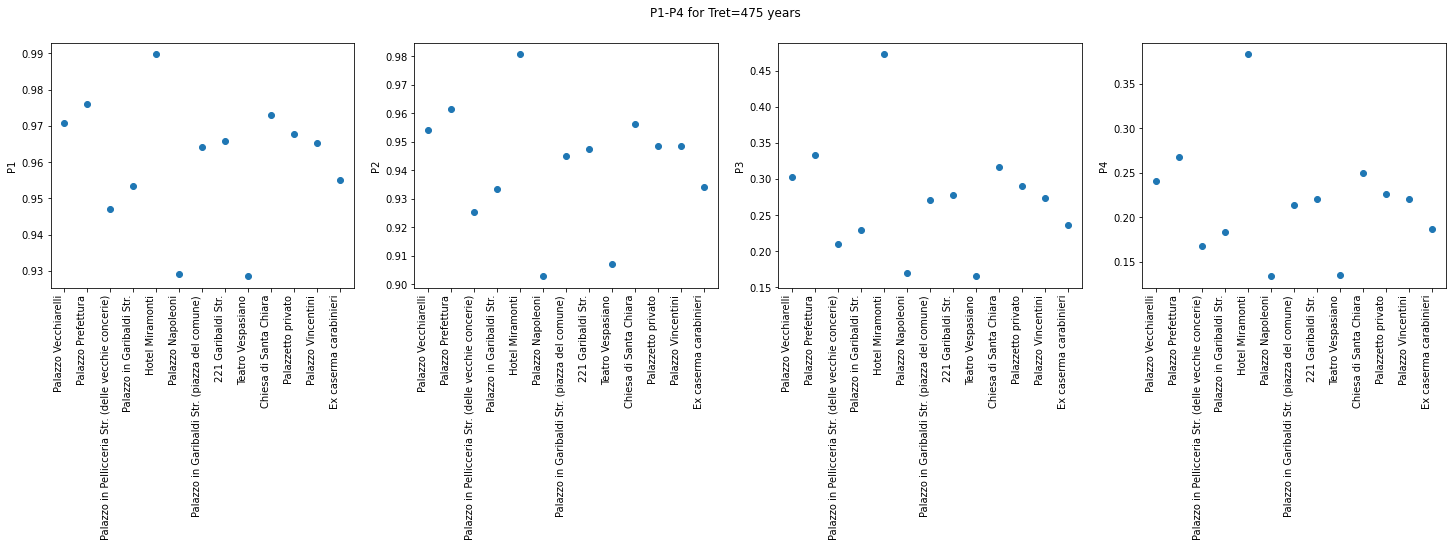

In [35]:
x = S.name
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(25, 5))
fig.suptitle('P1-P4 for Tret=475 years')
ax1.scatter(x, y1)
ax2.scatter(x, y2)
ax3.scatter(x, y3)
ax4.scatter(x, y4)
ax1.set_ylabel("P1")
ax2.set_ylabel("P2")
ax3.set_ylabel("P3")
ax4.set_ylabel("P4")
fig.autofmt_xdate(rotation=90)
#ax1.xaxis.set_tick_params(labelsize=18)
#ax1.yaxis.set_tick_params(labelsize=18)


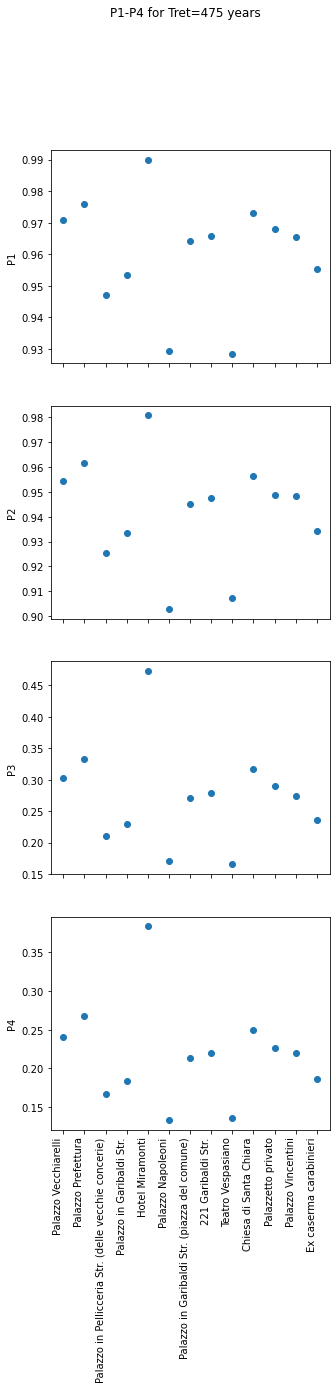

In [36]:
x = S.name
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(5, 20))
fig.suptitle('P1-P4 for Tret=475 years')
ax1.scatter(x, y1)
ax2.scatter(x, y2)
ax3.scatter(x, y3)
ax4.scatter(x, y4)
ax1.set_xlabel("id")
ax1.set_ylabel("P1")
ax2.set_ylabel("P2")
ax3.set_ylabel("P3")
ax4.set_ylabel("P4")
fig.autofmt_xdate(rotation=90)

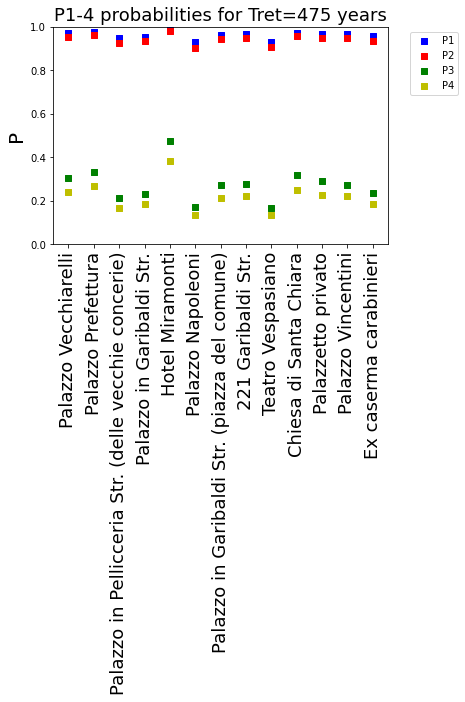

In [37]:
plt.scatter(x,y1, c='b', marker='s', label='P1')
plt.scatter(x, y2, c='r', marker='s', label='P2')
plt.scatter(x, y3, c='g', marker='s', label='P3')
plt.scatter(x, y4, c='y', marker='s', label='P4')
plt.legend(loc='upper left',bbox_to_anchor=(1.05, 1))
plt.ylim([0, 1])
plt.xticks(rotation = 90, fontsize=18)
#plt.xlabel("")
plt.title("P1-4 probabilities for Tret=475 years", fontsize=18)
plt.ylabel("P", fontsize=20)
plt.show()